In [1]:
import matplotlib.pyplot as plt
import re
import shutil
import seaborn as sns
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from sklearn.preprocessing import label_binarize
import torchvision
from sklearn.metrics import roc_curve,auc, precision_score,precision_recall_curve,recall_score,precision_recall_fscore_support,confusion_matrix
import numpy as np
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from PytMulticlass import Model_class
gpu_id = 3
!nvidia-smi



Wed Aug  4 21:58:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   51C    P2    64W / 250W |    859MiB / 11178MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 32%   65C    P2    75W / 250W |   7909MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
train_dataset = datasets.CIFAR10(root = "CIFAR10/",train=True,download=True,transform=transforms.ToTensor())
train_data,validation_data = torch.utils.data.dataset.random_split(train_dataset,[35000,15000])
train_loader = DataLoader(train_data,shuffle=True,batch_size=64)
validate_loader = DataLoader(validation_data,shuffle=True,batch_size=64)
test_dataset = datasets.CIFAR10(root='CIFAR10/',train=False,download=True,transform=transforms.ToTensor())
test_loader=DataLoader(test_dataset,shuffle=True,batch_size=64)

print(len(train_data))
print(len(test_dataset))
print(len(validation_data))

print(dir(datasets))

Files already downloaded and verified
Files already downloaded and verified
35000
10000
15000
['CIFAR10', 'CIFAR100', 'Caltech101', 'Caltech256', 'CelebA', 'Cityscapes', 'CocoCaptions', 'CocoDetection', 'DatasetFolder', 'EMNIST', 'FakeData', 'FashionMNIST', 'Flickr30k', 'Flickr8k', 'HMDB51', 'ImageFolder', 'ImageNet', 'KMNIST', 'Kinetics400', 'Kitti', 'LSUN', 'LSUNClass', 'MNIST', 'Omniglot', 'PhotoTour', 'Places365', 'QMNIST', 'SBDataset', 'SBU', 'SEMEION', 'STL10', 'SVHN', 'UCF101', 'USPS', 'VOCDetection', 'VOCSegmentation', 'VisionDataset', 'WIDERFace', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_utils', 'caltech', 'celeba', 'cifar', 'cityscapes', 'coco', 'fakedata', 'flickr', 'folder', 'hmdb51', 'imagenet', 'kinetics', 'kitti', 'lsun', 'mnist', 'omniglot', 'phototour', 'places365', 'sbd', 'sbu', 'semeion', 'stl10', 'svhn', 'ucf101', 'usps', 'utils', 'video_utils', 'vision', 'voc', 'widerface']


In [3]:
image,labels = next(iter(train_loader))
print(image.shape)

torch.Size([64, 3, 32, 32])


In [4]:
squeezenet = torchvision.models.squeezenet1_0(pretrained=True) # data again divided by 255

squeezenet.features[3].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[3].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[4].expand1x1 = nn.Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),groups=16)
squeezenet.features[4].expand3x3 = nn.Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=16)

squeezenet.features[5].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[5].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[7].expand1x1 = nn.Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1),groups=32)
squeezenet.features[7].expand3x3 = nn.Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=32)

squeezenet.features[8].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[8].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[9].expand1x1 = nn.Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1),groups=48)
squeezenet.features[9].expand3x3 = nn.Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=48)

squeezenet.features[10].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[10].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.features[12].expand1x1 = nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1),groups=64)
squeezenet.features[12].expand3x3 = nn.Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1),groups=64)

squeezenet.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), groups=16)
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), groups=16)
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
      (expand3x3_activation):

In [5]:
Losses_ = nn.CrossEntropyLoss()
lr = 3e-4
optimizer = optim.Adam(params=squeezenet.parameters(),lr=lr)
schedular = optim.lr_scheduler.StepLR(optimizer,step_size=26,gamma=0.1)
n_epochs=50

model = Model_class(squeezenet,num_classes=10,gpu_id=gpu_id)
model.print_params()
print()
model.train(train_loader,optimizer,Losses_,lr,n_epochs,validate_loader,schedular)

total_trainable_parameters are : 138954

epoch:[1/50],memory:[0.011749267578125/10.91650390625], lr:[0.0003]
train_accuracy:0.16823909640094262, train_loss:2.229586058604434
val_acc:0.21263297872340425,val_loss:2.150662617480501

epoch:[2/50],memory:[0.011749267578125/10.91650390625], lr:[0.0003]
train_accuracy:0.31030050279671356, train_loss:1.9796371172289526
val_acc:0.35777925531914895,val_loss:1.8551811010279553

epoch:[3/50],memory:[0.011749267578125/10.91650390625], lr:[0.0003]
train_accuracy:0.39237562028973805, train_loss:1.7639069840502695
val_acc:0.4048537234042553,val_loss:1.7126606038276186

epoch:[4/50],memory:[0.011749267578125/10.91650390625], lr:[0.0003]
train_accuracy:0.43373351406571636, train_loss:1.6557636343800826
val_acc:0.4345523050490846,val_loss:1.6270633398218357

epoch:[5/50],memory:[0.011749267578125/10.91650390625], lr:[0.0003]
train_accuracy:0.5098712131571727, train_loss:1.50329442978777
val_acc:0.48949468085106385,val_loss:1.5413131074702486

epoch:[6/50

epoch:[43/50],memory:[0.011749267578125/10.91650390625], lr:[2.9999999999999997e-05]
train_accuracy:0.6945188038963722, train_loss:0.9078029316783606
val_acc:0.6290558510638298,val_loss:1.1040055150681354

epoch:[44/50],memory:[0.011749267578125/10.91650390625], lr:[2.9999999999999997e-05]
train_accuracy:0.6932864325356004, train_loss:0.9077815227142417
val_acc:0.6286125888215734,val_loss:1.1114358810668297

epoch:[45/50],memory:[0.011749267578125/10.91650390625], lr:[2.9999999999999997e-05]
train_accuracy:0.6941270567817269, train_loss:0.9048768272129666
val_acc:0.6312943263256804,val_loss:1.0990909284733712

epoch:[46/50],memory:[0.011749267578125/10.91650390625], lr:[2.9999999999999997e-05]
train_accuracy:0.6960205015142396, train_loss:0.9000899198940074
val_acc:0.6319148936170212,val_loss:1.103848953196343

epoch:[47/50],memory:[0.011749267578125/10.91650390625], lr:[2.9999999999999997e-05]
train_accuracy:0.6956613998744344, train_loss:0.9016817927469502
val_acc:0.6329122340425531,

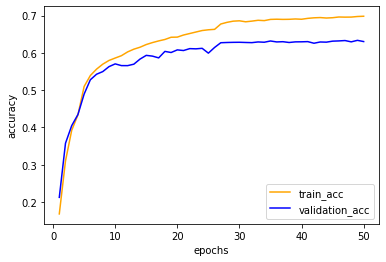

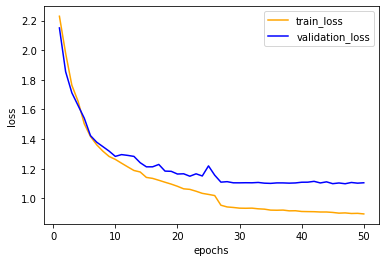

In [6]:
model.accuracy_curve()
model.loss_curve()

correct are 23921/35000
tensor(0.6835)


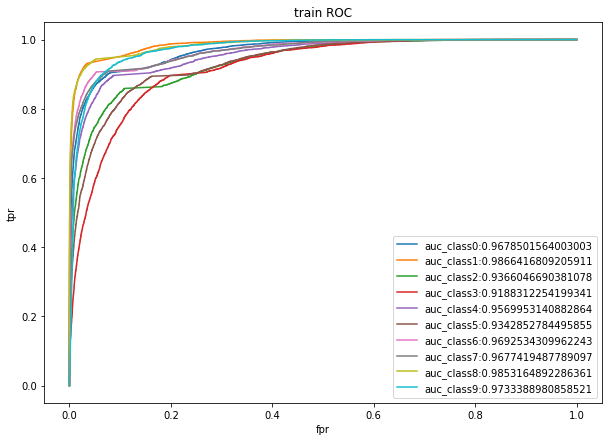

correct are 6317/10000
tensor(0.6317)


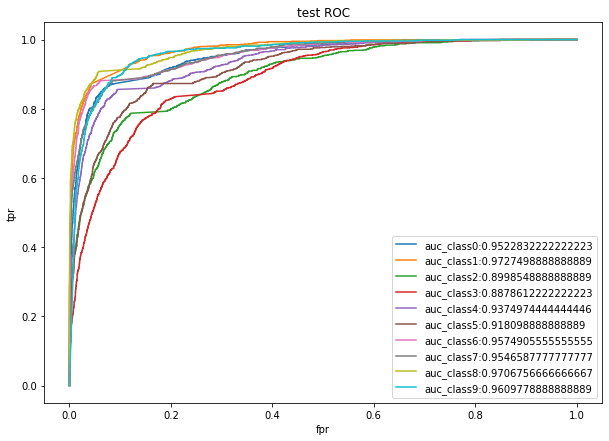

In [7]:
lab_train,pre_train,predict_train,acc_train = model.evaluate(train_loader,name='train')
print(acc_train)
model.plot_roc(fig_size=(10,7),name='train')
lab_test,pre_test,predict_test,acc_test=model.evaluate(test_loader,name='test')
print(acc_test)
model.plot_roc(fig_size=(10,7),name='test')

In [ ]:
cascadia code